In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


read csv data and standardize

In [186]:
cap = pd.read_csv('CAPUTLG3344S.csv')
ipg = pd.read_csv('IPG3344S.csv')
daup = pd.read_csv('DAUPSA.csv')

cap.columns = ["DATE", "CAPUTL"]
ipg.columns = ["DATE", "IPG"]
daup.columns = ["DATE", "DAUP"]

cap["DATE"] = pd.to_datetime(cap["DATE"])
ipg["DATE"] = pd.to_datetime(ipg["DATE"])
daup["DATE"] = pd.to_datetime(daup["DATE"])

merge data

In [187]:
semiconductor = cap.merge(ipg, on='DATE', how='inner')
semiconductor = semiconductor.merge(daup, on='DATE', how='inner')

add features (lag1 = value at 1 month previous, lag3 = value at 3 month previous)

In [188]:
# getting lag1, lag3 for CAPUTL and IPG
semiconductor["CAPUTL_lag1"] = semiconductor["CAPUTL"].shift(1)
semiconductor["CAPUTL_lag3"] = semiconductor["CAPUTL"].shift(3)

semiconductor["IPG_lag1"] = semiconductor["IPG"].shift(1)
semiconductor["IPG_lag3"] = semiconductor["IPG"].shift(3)

# getting lag4 for DAUP
semiconductor["DAUP_lag3"] = semiconductor["DAUP"].shift(3)

# getting 3 window average for CAPUTL, IPG
semiconductor["CAPUTL_ma3"] = semiconductor["CAPUTL"].rolling(window=3).mean()
semiconductor["IPG_ma3"] = semiconductor["IPG"].rolling(window=3).mean()

# adding month and quarter
semiconductor["Month"] = semiconductor["DATE"].dt.month
semiconductor["Quarter"] = semiconductor["DATE"].dt.quarter

# adding interaction variable
semiconductor["IPG_x_DAUP"] = semiconductor["IPG"] * semiconductor["DAUP"]

# dropping all na rows that come with the windows and the shifting
semiconductor_model = semiconductor.dropna().copy()

semiconductor_model

,DATE,CAPUTL,IPG,DAUP,CAPUTL_lag1,CAPUTL_lag3,IPG_lag1,IPG_lag3,DAUP_lag3,CAPUTL_ma3,IPG_ma3,Month,Quarter,IPG_x_DAUP
3,1993-04-01,79.6596,0.4391,510.2,80.1333,80.2551,0.4375,0.4288,512.9,79.997233,0.436667,4,2,224.02882
4,1993-05-01,79.8275,0.4440,512.8,79.6596,80.1988,0.4391,0.4334,503.8,79.873467,0.440200,5,2,227.68320
5,1993-06-01,80.5937,0.4523,489.5,79.8275,80.1333,0.4440,0.4375,498.1,80.026933,0.445133,6,2,221.40085
6,1993-07-01,80.2468,0.4545,468.1,80.5937,79.6596,0.4523,0.4391,510.2,80.222667,0.450267,7,3,212.75145
7,1993-08-01,80.4144,0.4599,457.1,80.2468,79.8275,0.4545,0.4440,512.8,80.418300,0.455567,8,3,210.22029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,2025-04-01,78.2049,162.2271,112.3,77.9160,79.5424,159.2281,158.0732,96.6,78.463567,160.380933,4,2,18218.10333
388,2025-05-01,77.9551,164.2369,108.4,78.2049,79.2698,162.2271,159.6876,104.5,78.025333,161.897367,5,2,17803.27996
389,2025-06-01,76.2169,163.1589,112.3,77.9551,77.9160,164.2369,159.2281,114.6,77.458967,163.207633,6,2,18322.74447
390,2025-07-01,78.7498,171.3216,113.2,76.2169,78.2049,163.1589,162.2271,112.3,77.640600,166.239133,7,3,19393.60512


split into training/test

In [189]:
semiconductor_train = semiconductor_model[semiconductor_model['DATE'] < '2020-01-01']
semiconductor_test = semiconductor_model[semiconductor_model['DATE'] >= '2020-01-01']

define features to model (x), variable to predict (y)

In [190]:
y_feature = "CAPUTL"
features =[
        "CAPUTL_lag1",
        "CAPUTL_lag3",
        "IPG_lag1",
        "IPG_lag3",
        "DAUP_lag3",
        "CAPUTL_ma3",
        "IPG_ma3",
        "Month",
        "Quarter",
        "IPG_x_DAUP",
    ]

x_train = semiconductor_train[features]
y_train = semiconductor_train[y_feature]

x_train = sm.add_constant(x_train)

compute initial VIFs

In [191]:
vif_vals = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]
vif = pd.DataFrame({"variable": x_train.columns, 'VIF': vif_vals}).sort_values('VIF', ascending = False)
vif

,variable,VIF
7,IPG_ma3,66916.466714
3,IPG_lag1,60378.843153
4,IPG_lag3,1777.067579
6,CAPUTL_ma3,744.234911
1,CAPUTL_lag1,692.187123
0,const,167.142363
9,Quarter,17.808447
8,Month,17.784543
2,CAPUTL_lag3,17.656034
10,IPG_x_DAUP,14.801295


train model

In [192]:
lin_model = sm.OLS(y_train, x_train).fit()
lin_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 CAPUTL   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     5286.
Date:                Fri, 12 Dec 2025   Prob (F-statistic):               0.00
Time:                        01:58:50   Log-Likelihood:                -291.90
No. Observations:                 321   AIC:                             605.8
Df Residuals:                     310   BIC:                             647.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.5781      0.441      3.577      0.000       0.710       2.446
CAPUTL_lag1    -1.1670      0.114    -10.230      0.000      -1.391      -0.943
CAPUTL_lag3    -0.4901      0.018    -26.905      0.000      -0.526      -0.454
IPG_lag1       -0.1267      0.235     -0.540      0.590      -0.588       0.335
IPG_lag3       -0.0113      0.041     -0.278      0.781      -0.091       0.069
DAUP_lag3       0.0006      0.001      1.128      0.260      -0.000       0.002
CAPUTL_ma3      2.6360      0.120     22.044      0.000       2.401       2.871
IPG_ma3         0.1440      0.247      0.583      0.560      -0.342       0.630
Month           0.0048      0.042      0.115      0.909      -0.078       0.087
Quarter        -0.0677      0.129     -0.524      0.601      -0.322       0.187
IPG_x_DAUP  -2.396e-05    1.3e-05     -1.836      0.067   -4.96e-05    1.71e-06
==============================================================================
Omnibus:                       33.331   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              175.307
Skew:                          -0.082   Prob(JB):                     8.56e-39
Kurtosis:                       6.617   Cond. No.                     1.93e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.93e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

initially, we can see that IPG_ma3 and CAPUTL_ma3 have very high VIF, which makes sense because they are basically perfectly collinear with their lag1-lag3 counterparts. month and quarter also have decently high VIF, since they are also directly derived from each other

thus, we will first try without both ma3s and quarter. 

In [193]:
new_features = [
        "CAPUTL_lag1",
        "CAPUTL_lag3",
        "IPG_lag1",
        "IPG_lag3",
        "DAUP_lag3",
        "Month",
        "IPG_x_DAUP",
    ]

x_train = semiconductor_train[new_features]
y_train = semiconductor_train[y_feature]

x_train = sm.add_constant(x_train)

x_train

# computer new VIFs
vif_vals = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]
vif = pd.DataFrame({"variable": x_train.columns, 'VIF': vif_vals}).sort_values('VIF', ascending = False)
print(vif)

# train again
lin_model = sm.OLS(y_train, x_train).fit()
lin_model.summary()

      variable          VIF
3     IPG_lag1  1607.438204
4     IPG_lag3  1521.686109
0        const   156.329643
2  CAPUTL_lag3    15.739817
1  CAPUTL_lag1    14.906364
7   IPG_x_DAUP    14.660989
5    DAUP_lag3     2.739865
6        Month     1.004334


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 CAPUTL   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1971.
Date:                Fri, 12 Dec 2025   Prob (F-statistic):          1.25e-254
Time:                        01:58:50   Log-Likelihood:                -506.35
No. Observations:                 321   AIC:                             1029.
Df Residuals:                     313   BIC:                             1059.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.9552      0.828      4.776      0.000       2.326       5.584
CAPUTL_lag1     1.3051      0.032     40.162      0.000       1.241       1.369
CAPUTL_lag3    -0.3586      0.033    -10.742      0.000      -0.424      -0.293
IPG_lag1       -0.0205      0.074     -0.276      0.783      -0.167       0.126
IPG_lag3        0.0334      0.073      0.457      0.648      -0.110       0.177
DAUP_lag3       0.0013      0.001      1.220      0.223      -0.001       0.003
Month          -0.0263      0.019     -1.361      0.174      -0.064       0.012
IPG_x_DAUP  -5.085e-05   2.52e-05     -2.018      0.044      -0.000   -1.26e-06
==============================================================================
Omnibus:                       49.840   Durbin-Watson:                   1.576
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              142.864
Skew:                          -0.695   Prob(JB):                     9.49e-32
Kurtosis:                       5.958   Cond. No.                     1.86e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.86e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

now, we have better VIFs, but there is still high collinearity for the variables with both lag1 and lag3, which also makes sense, since lag3 comes from lag1. Now, we can try to get rid of lag1, and predict using the previous 3 month value

In [194]:
final_features = [
        "CAPUTL_lag1",
        "CAPUTL_lag3",
        "IPG_lag3",
        "DAUP_lag3",
        "Month",
        "IPG_x_DAUP",
    ]

x_train = semiconductor_train[final_features]
y_train = semiconductor_train[y_feature]

x_train = sm.add_constant(x_train)

x_train

# computer new VIFs
vif_vals = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]
vif = pd.DataFrame({"variable": x_train.columns, 'VIF': vif_vals}).sort_values('VIF', ascending = False)
print(vif)

# train again
lin_model = sm.OLS(y_train, x_train).fit()
lin_model.summary()

      variable         VIF
0        const  145.674114
3     IPG_lag3   16.496613
6   IPG_x_DAUP   13.766226
2  CAPUTL_lag3    9.098992
1  CAPUTL_lag1    8.656968
4    DAUP_lag3    2.498903
5        Month    1.001568


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 CAPUTL   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     2307.
Date:                Fri, 12 Dec 2025   Prob (F-statistic):          2.58e-256
Time:                        01:58:50   Log-Likelihood:                -506.38
No. Observations:                 321   AIC:                             1027.
Df Residuals:                     314   BIC:                             1053.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.8956      0.798      4.881      0.000       2.325       5.466
CAPUTL_lag1     1.2993      0.025     52.544      0.000       1.251       1.348
CAPUTL_lag3    -0.3527      0.025    -13.913      0.000      -0.403      -0.303
IPG_lag3        0.0134      0.008      1.762      0.079      -0.002       0.028
DAUP_lag3       0.0014      0.001      1.365      0.173      -0.001       0.003
Month          -0.0260      0.019     -1.350      0.178      -0.064       0.012
IPG_x_DAUP  -5.257e-05   2.44e-05     -2.156      0.032      -0.000   -4.59e-06
==============================================================================
Omnibus:                       48.701   Durbin-Watson:                   1.576
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.255
Skew:                          -0.684   Prob(JB):                     1.57e-30
Kurtosis:                       5.897   Cond. No.                     1.80e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

now we can do cross-validation, instead of shuffling, we can train on x years, predict the month after, then train on x+1 years, predict the month after, repeating until the end of the dataset

In [195]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

initial_train_size = 200
horizon = 1

errors = []
predictions = []
actuals = []
dates = []

y_full = semiconductor_model[y_feature]

for t in range(initial_train_size, len(y_full) - horizon):
    # Training data
    cv_X_train = semiconductor_model.iloc[:t][final_features]
    cv_y_train = semiconductor_model.iloc[:t][y_feature]

    # Test point
    X_test = semiconductor_model.iloc[t:t+horizon][final_features]
    # print(f'x test at {t} is {X_test}')
    y_test = y_full.iloc[t:t+horizon]

    # Fit model
    model = sm.OLS(cv_y_train, cv_X_train)
    results = model.fit()

    # Predict
    y_pred = results.predict(X_test)

    # Store results
    errors.append(y_test.values[0] - y_pred.values[0])
    predictions.append(y_pred.values[0])
    actuals.append(y_test.values[0])
    dates.append(semiconductor_model["DATE"].iloc[t])

performance

In [196]:
rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)

print(f"Rolling CV RMSE: {rmse:.3f}")
print(f"Rolling CV MAE: {mae:.3f}")


Rolling CV RMSE: 1.159
Rolling CV MAE: 0.889


compare to baseline

In [197]:
baseline_preds = semiconductor_model["CAPUTL_lag1"].iloc[initial_train_size:len(y_full)-horizon].values
baseline_actuals = actuals

baseline_rmse = np.sqrt(mean_squared_error(baseline_actuals, baseline_preds))
baseline_mae = mean_absolute_error(baseline_actuals, baseline_preds)

print(f"Baseline RMSE: {baseline_rmse:.3f}")
print(f"Baseline MAE: {baseline_mae:.3f}")

Baseline RMSE: 1.200
Baseline MAE: 0.895


visualize

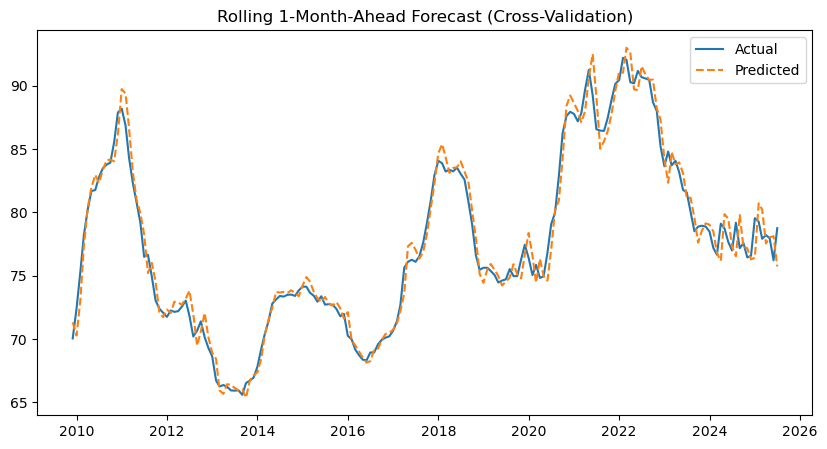

In [198]:
plt.figure(figsize=(10,5))
plt.plot(dates, actuals, label="Actual")
plt.plot(dates, predictions, label="Predicted", linestyle="--")
plt.title("Rolling 1-Month-Ahead Forecast (Cross-Validation)")
plt.legend()
plt.show()


time to test on truely unseen data

In [199]:
y_test = semiconductor_test[y_feature]

X_test = semiconductor_test[final_features]
X_test = sm.add_constant(X_test)

final_model = sm.OLS(y_train, x_train).fit()

y_test_pred = final_model.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"TEST RMSE: {test_rmse:.3f}")
print(f"TEST MAE : {test_mae:.3f}")

TEST RMSE: 1.583
TEST MAE : 1.333


baseline:

In [200]:
baseline_test_pred = semiconductor_test["CAPUTL_lag1"]

baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_test_pred))
baseline_mae = mean_absolute_error(y_test, baseline_test_pred)

print(f"BASELINE RMSE: {baseline_rmse:.3f}")
print(f"BASELINE MAE : {baseline_mae:.3f}")

BASELINE RMSE: 1.421
BASELINE MAE : 1.127


visualization

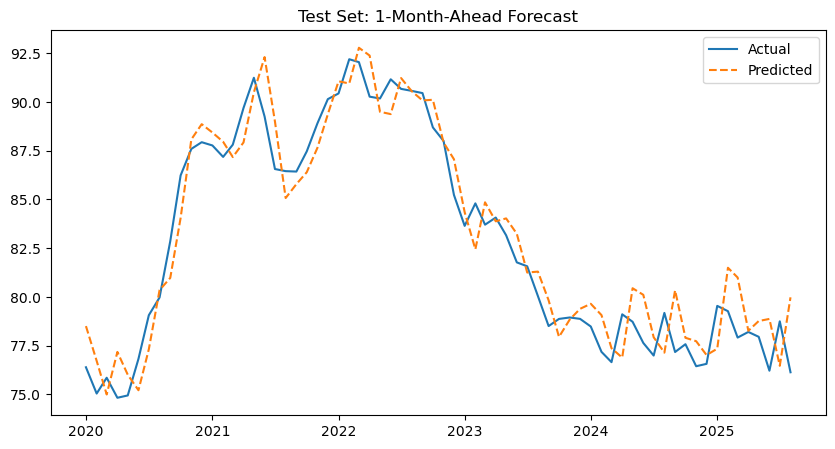

In [201]:
plt.figure(figsize=(10,5))
plt.plot(semiconductor_test["DATE"], y_test, label="Actual")
plt.plot(semiconductor_test["DATE"], y_test_pred, label="Predicted", linestyle="--")
plt.title("Test Set: 1-Month-Ahead Forecast")
plt.legend()
plt.show()
